In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil
import sys

import numpy as np
from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sn
sn.set()

import pandas as pd

import random
import tensorflow as tf
#from tensorflow.contrib.layers import apply_regularization, l2_regularizer #Paquetes eliminados

import bottleneck as bn

import os


In [ ]:
#Cargando datos
raw_data = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/ml-20m/ml-20m/ratings.csv", header = 0)

Visualización de datos:

In [ ]:
raw_data.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


Binarizando datos (Tomando los datos con rating >= 4).

Se tiene una base de datos de calificaciones desde 0.5 a 5.  

In [ ]:
print("# Ratings < 0.5: ",sum(raw_data['rating']<0.5))
print("# Ratings = 0.5: ",sum(raw_data['rating']==0.5))
print("# Ratings > 3.5: ",sum(raw_data['rating']>3.5))
print("# Ratings = 4.5: ",sum(raw_data['rating']==4.5))

raw_data = raw_data[raw_data['rating']>3.5]
raw_data.head()

# Ratings < 0.5:  0
# Ratings = 0.5:  239125
# Ratings > 3.5:  9995410
# Ratings = 4.5:  1534824


,userId,movieId,rating,timestamp
6,1,151,4.0,1094785734
7,1,223,4.0,1112485573
8,1,253,4.0,1112484940
9,1,260,4.0,1112484826
10,1,293,4.0,1112484703


# **Procedimiento de división de datos**
* Seleccionar 10K usuarios como usuarios excluidos, 10K usuarios como usuarios de validación y el resto de los usuarios para el entrenamiento.
* Utilizar todos los ítems de los usuarios de entrenamiento como conjunto de ítems.
* Para cada usuario de validación y de prueba, submuestrear el 80% como datos plegables y el resto para la predicción.

In [ ]:
#Función que cuenta el número de determinados ítems agrupados 
print(raw_data[['movieId']].groupby('movieId', as_index=False).size)
def get_count( data, item ):
    playcount_groupbyid = data[[item]].groupby(item, as_index=False) #Agrupa por ítems y cuenta el # de c/grupo
    count = playcount_groupbyid.size()['size']
    return count

<bound method GroupBy.size of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x7ff7bde918d0>>


In [ ]:
get_count(raw_data, 'userId')

0          88
1          43
2         145
3          16
4          50
         ... 
138282     27
138283     86
138284      5
138285     61
138286    301
Name: size, Length: 138287, dtype: int64

In [ ]:
#Función de tripletas filtradas (datos, conteo de usuarios y conteo de ítems)
def filter_triplets( data, min_uc = 5, min_sc = 5 ):
    #Considerando tripletas solo para ítems que han sido seleccionadas por al menos min_sc usuarios
    if min_sc > 0:
        item_count = get_count( data, 'movieId')
        data = data[ data[ 'movieId' ].isin(item_count.index[ item_count >= min_sc ] ) ]  #i.sin donde see encuentran los valores en el data frame
    #Considerando tripletas para usuarios que interactuaron con al menos min_uc ítems                                         
    if min_uc > 0:
        user_count = get_count( data, 'userId' )
        data = data[ data[ 'userId' ].isin(user_count.index[ user_count >= min_uc ] ) ]  #i.sin donde see encuentran los valores en el data frame                                    
    #Actualizando el contador de items y de usuarios despues de los filtros
    item_count = get_count( data, 'movieId' )
    user_count = get_count( data, 'userId' )
    return data, user_count, item_count 


Considerando ítems que fueron calificados por al menos 5 usuarios y usuarios que calificaron al menos 5 películas




In [ ]:
raw_data, user_activity, item_popularity = filter_triplets(raw_data)

**Calculando 'dispersión'**
* Se calcula el numerador de la métrica de dispersión contando el número total de calificaciones contenidas en la matriz de calificaciones.
* Se calcula el denominador de la métrica de dispersión multiplicando el número de usuarios por el número de películas en la matriz de clasificación.
* Se calcula e imprime la dispersión dividiendo el numerador por el denominador, restando de 1 y multiplicando por 100. Se agrega 1.0 para garantizar que la dispersión se devuelva como un decimal y no como un número entero.

In [ ]:
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("Después de los filtros, hay %d eventos de %d usuarios y %d películas (ítems) (dispersión: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

Después de los filtros, hay 8323972 eventos de 135308 usuarios y 7567 películas (ítems) (dispersión: 0.813%)


In [ ]:
print(raw_data.shape)
print(item_popularity.shape)
print(user_activity.shape)

(8323972, 4)
(7567,)
(135308,)


In [ ]:
#Index único de usuario
unique_uid = user_activity.index
np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)#permutando los indices de los usuarios
unique_uid = unique_uid[idx_perm]
print(unique_uid.size)

135308


Creando train/validation/test para usuarios

In [ ]:
n_users = unique_uid.size
n_heldout_users = 10000

tr_users = unique_uid[:(n_users - n_heldout_users * 2)] #135308-20000 = 115308
#10000
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)] #115308+10000 =125308 
#10000
te_users = unique_uid[(n_users - n_heldout_users):] #125308 + 10000 = 135308

In [ ]:
#Seleccionando a todos los usuarios de entrenamiento de nuestros datos
train_plays = raw_data.loc[raw_data['userId'].isin(tr_users)]


In [ ]:
#Películas sin repeticion
unique_sid = pd.unique( train_plays[ 'movieId'] )

In [ ]:
#Diccionario para usuarios 
profile2id = dict((pid,i) for (i, pid) in enumerate(unique_uid))
print(len(profile2id))
#Diccionario para películas (enumero los índices)
show2id   = dict((sid, i) for (i, sid) in enumerate(unique_sid))
print(len(show2id))

135308
7550


Escribiendo archivos de películas

In [ ]:
DATA_DIR = '/content/drive/MyDrive'
pro_dir = os.path.join(DATA_DIR, 'pro_sg')

if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

Función para generar datos de entrenamiento y datos de prueba

In [ ]:
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('userId') #Agrupando por usuario
    tr_list, te_list = list(), list() 

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group) #numero de items por usuario

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 1000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

In [ ]:
#Ubicación usuarios para validación 
vad_plays = raw_data.loc[raw_data['userId'].isin(vd_users)]
#Ubicación películas con usuarios de validación
vad_plays = vad_plays.loc[vad_plays['movieId'].isin(unique_sid)]

In [ ]:
#Dividiendo datos de peliculas de usuarios de validación en train y test data sets
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)


0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled


In [ ]:
#Ubicación de usuarios en test data
test_plays = raw_data.loc[raw_data['userId'].isin(te_users)]
#Ubicación de items en test data
test_plays = test_plays.loc[test_plays['movieId'].isin(unique_sid)]

In [ ]:
#Dividiendo datos de peliculas de usuarios de los datos de prueba (test sets) en train y test data sets
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)


0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled


Guardando los datos en formato user_index e item_index


In [ ]:
def numerize(data):
    uid = list(map(lambda x: profile2id[x], data['userId']))
    sid = list(map(lambda x: show2id[x],   data['movieId']))
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [ ]:
train_data = numerize(train_plays)
train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)

In [ ]:
vad_data_tr = numerize(vad_plays_tr)
vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

In [ ]:
vad_data_te = numerize(vad_plays_te)
vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

In [ ]:
test_data_tr = numerize(test_plays_tr)
test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)

In [ ]:
test_data_te = numerize(test_plays_te)
test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)
# print(test_data_te)

In [ ]:

# import tensorflow.compat.v2 as tf
# from tensorflow.keras import l2, regularizers


class MultiDAE(object):
    def __init__(self, p_dims, q_dims=None, lam=0.01, lr=1e-3, random_seed=None):
        self.p_dims = p_dims
        if q_dims is None:
            self.q_dims = p_dims[::-1]
        else:
            assert q_dims[0] == p_dims[-1], "Input and output dimension must equal each other for autoencoders."
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q-network mismatches."
            self.q_dims = q_dims
        self.dims = self.q_dims + self.p_dims[1:]
        
        self.lam = lam
        self.lr = lr
        self.random_seed = random_seed

        self.construct_placeholders()

    def construct_placeholders(self):        
        self.input_ph = tf.placeholder(
            dtype=tf.float32, shape=[None, self.dims[0]])
        self.keep_prob_ph = tf.placeholder_with_default(1.0, shape=None)

    def build_graph(self):

        self.construct_weights()

        saver, logits = self.forward_pass()
        log_softmax_var = tf.nn.log_softmax(logits)

        # per-user average negative log-likelihood
        neg_ll = -tf.reduce_mean(tf.reduce_sum(
            log_softmax_var * self.input_ph, axis=1))
        # apply regularization to weights
        reg = l2_regularizer(self.lam)
        reg_var = apply_regularization(reg, self.weights)
        # tensorflow l2 regularization multiply 0.5 to the l2 norm
        # multiply 2 so that it is back in the same scale
        loss = neg_ll + 2 * reg_var
        
        train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)

        # add summary statistics
        tf.summary.scalar('negative_multi_ll', neg_ll)
        tf.summary.scalar('loss', loss)
        merged = tf.summary.merge_all()
        return saver, logits, loss, train_op, merged

    def forward_pass(self):
        # construct forward graph        
        h = tf.nn.l2_normalize(self.input_ph, 1)
        h = tf.nn.dropout(h, self.keep_prob_ph)
        
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights) - 1:
                h = tf.nn.tanh(h)
        return tf.train.Saver(), h

    def construct_weights(self):

        self.weights = []
        self.biases = []
        
        # define weights
        for i, (d_in, d_out) in enumerate(zip(self.dims[:-1], self.dims[1:])):
            weight_key = "weight_{}to{}".format(i, i+1)
            bias_key = "bias_{}".format(i+1)
            
            self.weights.append(tf.Variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases.append(tf.Variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights[-1])
            tf.summary.histogram(bias_key, self.biases[-1])
            

In [ ]:
class MultiVAE(MultiDAE):

    def construct_placeholders(self):
        super(MultiVAE, self).construct_placeholders()

        # placeholders with default values when scoring
        self.is_training_ph = tf.placeholder_with_default(0., shape=None)
        self.anneal_ph = tf.placeholder_with_default(1., shape=None)
        
    def build_graph(self):
        self._construct_weights()

        saver, logits, KL = self.forward_pass()
        log_softmax_var = tf.nn.log_softmax(logits)

        neg_ll = -tf.reduce_mean(tf.reduce_sum(
            log_softmax_var * self.input_ph,
            axis=-1))
        # apply regularization to weights
        reg = l2_regularizer(self.lam)
        
        reg_var = apply_regularization(reg, self.weights_q + self.weights_p)
        # tensorflow l2 regularization multiply 0.5 to the l2 norm
        # multiply 2 so that it is back in the same scale
        neg_ELBO = neg_ll + self.anneal_ph * KL + 2 * reg_var
        
        train_op = tf.train.AdamOptimizer(self.lr).minimize(neg_ELBO)

        # add summary statistics
        tf.summary.scalar('negative_multi_ll', neg_ll)
        tf.summary.scalar('KL', KL)
        tf.summary.scalar('neg_ELBO_train', neg_ELBO)
        merged = tf.summary.merge_all()

        return saver, logits, neg_ELBO, train_op, merged
    
    def q_graph(self):
        mu_q, std_q, KL = None, None, None
        
        h = tf.nn.l2_normalize(self.input_ph, 1)
        h = tf.nn.dropout(h, self.keep_prob_ph)
        
        for i, (w, b) in enumerate(zip(self.weights_q, self.biases_q)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights_q) - 1:
                h = tf.nn.tanh(h)
            else:
                mu_q = h[:, :self.q_dims[-1]]
                logvar_q = h[:, self.q_dims[-1]:]

                std_q = tf.exp(0.5 * logvar_q)
                KL = tf.reduce_mean(tf.reduce_sum(
                        0.5 * (-logvar_q + tf.exp(logvar_q) + mu_q**2 - 1), axis=1))
        return mu_q, std_q, KL

    def p_graph(self, z):
        h = z
        
        for i, (w, b) in enumerate(zip(self.weights_p, self.biases_p)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights_p) - 1:
                h = tf.nn.tanh(h)
        return h

    def forward_pass(self):
        # q-network
        mu_q, std_q, KL = self.q_graph()
        epsilon = tf.random_normal(tf.shape(std_q))

        sampled_z = mu_q + self.is_training_ph *\
            epsilon * std_q

        # p-network
        logits = self.p_graph(sampled_z)
        
        return tf.train.Saver(), logits, KL

    def _construct_weights(self):
        self.weights_q, self.biases_q = [], []
        
        for i, (d_in, d_out) in enumerate(zip(self.q_dims[:-1], self.q_dims[1:])):
            if i == len(self.q_dims[:-1]) - 1:
                # we need two sets of parameters for mean and variance,
                # respectively
                d_out *= 2
            weight_key = "weight_q_{}to{}".format(i, i+1)
            bias_key = "bias_q_{}".format(i+1)
            
            self.weights_q.append(tf.Variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases_q.append(tf.Variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights_q[-1])
            tf.summary.histogram(bias_key, self.biases_q[-1])
            
        self.weights_p, self.biases_p = [], []

        for i, (d_in, d_out) in enumerate(zip(self.p_dims[:-1], self.p_dims[1:])):
            weight_key = "weight_p_{}to{}".format(i, i+1)
            bias_key = "bias_p_{}".format(i+1)
            self.weights_p.append(tf.Variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases_p.append(tf.Variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights_p[-1])
            tf.summary.histogram(bias_key, self.biases_p[-1])

In [ ]:
unique_sid = list()
with open(os.path.join(pro_dir, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

n_items = len(unique_sid)

In [ ]:
def load_train_data(csv_file):
    tp = pd.read_csv(csv_file)
    n_users = tp['uid'].max() + 1

    rows, cols = tp['uid'], tp['sid']
    data = sparse.csr_matrix((np.ones_like(rows),
                             (rows, cols)), dtype='float64',
                             shape=(n_users, n_items))
    return data

In [ ]:
train_data = load_train_data(os.path.join(pro_dir, 'train.csv'))

In [ ]:
def load_tr_te_data(csv_file_tr, csv_file_te):
    tp_tr = pd.read_csv(csv_file_tr)
    tp_te = pd.read_csv(csv_file_te)

    start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
    end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    data_te = sparse.csr_matrix((np.ones_like(rows_te),
                             (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    return data_tr, data_te

In [ ]:
vad_data_tr, vad_data_te = load_tr_te_data(os.path.join(pro_dir, 'validation_tr.csv'),
                                           os.path.join(pro_dir, 'validation_te.csv'))

In [ ]:
N = train_data.shape[0]
idxlist = range(N)

# training batch size
batch_size = 500
batches_per_epoch = int(np.ceil(float(N) / batch_size))

N_vad = vad_data_tr.shape[0]
idxlist_vad = range(N_vad)

# validation batch size (since the entire validation set might not fit into GPU memory)
batch_size_vad = 2000

# the total number of gradient updates for annealing
total_anneal_steps = 200000
# largest annealing parameter
anneal_cap = 0.2

In [ ]:
def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    # X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted
    # topk predicted score
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG

In [ ]:
def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

In [ ]:
p_dims = [200, 600, n_items]

In [ ]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior() 
import tensorflow as tf2
vae = MultiVAE(p_dims, lam=0.0, random_seed=98765)

saver, logits_var, loss_var, train_op_var, merged_var = vae.build_graph()

ndcg_var = tf.Variable(0.0)

ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("dropout/Mul:0", shape=(?, 7550), dtype=float32)


In [ ]:
arch_str = "I-%s-I" % ('-'.join([str(d) for d in vae.dims[1:-1]]))

In [ ]:
log_dir = '/volmount/log/ml-20m/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

print("log directory: %s" % log_dir)
summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

log directory: /volmount/log/ml-20m/VAE_anneal200.0K_cap2.0E-01/I-200-I


In [ ]:
chkpt_dir = '/volmount/chkpt/ml-20m/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if not os.path.isdir(chkpt_dir):
    os.makedirs(chkpt_dir) 
    
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: /volmount/chkpt/ml-20m/VAE_anneal200.0K_cap2.0E-01/I-200-I


In [ ]:
n_epochs = 200

In [ ]:
import tensorflow as tf

print(tf.__version__)

2.9.0-dev20220315


In [ ]:
# For CPU only
# !pip install tf-nightly  

# # For GPU support
# !pip install -U tf-nightly-gpu
# saver, logits_var, loss_var, train_op_var, merged_var = vae.build_graph()
ndcgs_vad = []

with tf.compat.v1.Session() as sess:

    init = tf.compat.v1.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf

    update_count = 0.0
    
    for epoch in range(n_epochs):
        np.random.shuffle(idxlist)
        # train for one epoch
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = train_data[idxlist[st_idx:end_idx]]
            
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')           
            
            if total_anneal_steps > 0:
                anneal = min(anneal_cap, 1. * update_count / total_anneal_steps)
            else:
                anneal = anneal_cap
            
            feed_dict = {vae.input_ph: X, 
                         vae.keep_prob_ph: 0.5, 
                         vae.anneal_ph: anneal,
                         vae.is_training_ph: 1}        
            sess.run(train_op_var, feed_dict=feed_dict)

            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                summary_writer.add_summary(summary_train, 
                                           global_step=epoch * batches_per_epoch + bnum) 
            
            update_count += 1
        
        # compute validation NDCG
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = vad_data_tr[idxlist_vad[st_idx:end_idx]]

            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
        
            pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X} )
            # exclude examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, vad_data_te[idxlist_vad[st_idx:end_idx]]))
        
        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        ndcgs_vad.append(ndcg_)
        # merged_valid_val = sess.run(merged_valid, feed_dict={ndcg_var: ndcg_, ndcg_dist_var: ndcg_dist})
        # sess.run(logits_var, feed_dict={dae.input_ph: X} )
        # summary_writer.add_summary(merged_valid, epoch)

        # update the best model (if necessary)
        if ndcg_ > best_ndcg:
            saver.save(sess, '{}/model'.format(chkpt_dir))
            best_ndcg = ndcg_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


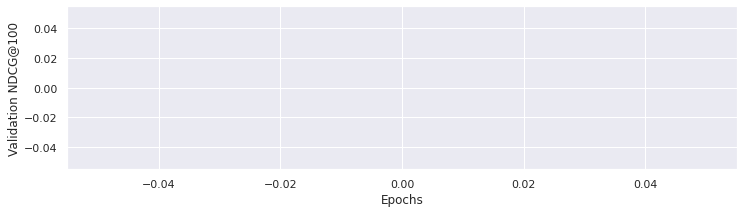

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(ndcgs_vad)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
pass

In [ ]:
test_data_tr, test_data_te = load_tr_te_data(
    os.path.join(pro_dir, 'test_tr.csv'),
    os.path.join(pro_dir, 'test_te.csv'))

In [ ]:
N_test = test_data_tr.shape[0]
idxlist_test = range(N_test)

batch_size_test = 2000

In [ ]:
tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0)
saver, logits_var, _, _, _ = vae.build_graph() 

AttributeError: ignored

In [ ]:
chkpt_dir = '/volmount/chkpt/ml-20m/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: /volmount/chkpt/ml-20m/VAE_anneal200.0K_cap2.0E-01/I-200-I


In [ ]:
n100_list, r20_list, r50_list = [], [], []

with tf.compat.v1.Session() as sess:
    saver.restore(sess, '{}/model'.format(chkpt_dir))

    for bnum, st_idx in enumerate(range(0, N_test, batch_size_test)):
        end_idx = min(st_idx + batch_size_test, N_test)
        X = test_data_tr[idxlist_test[st_idx:end_idx]]

        if sparse.isspmatrix(X):
            X = X.toarray()
        X = X.astype('float32')

        pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X})
        # exclude examples from training and validation (if any)
        pred_val[X.nonzero()] = -np.inf
        n100_list.append(NDCG_binary_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=100))
        r20_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=20))
        r50_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=50))
    
n100_list = np.concatenate(n100_list)
r20_list = np.concatenate(r20_list)
r50_list = np.concatenate(r50_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
print("Test NDCG@100=%.5f (%.5f)" % (np.mean(n100_list), np.std(n100_list) / np.sqrt(len(n100_list))))
print("Test Recall@20=%.5f (%.5f)" % (np.mean(r20_list), np.std(r20_list) / np.sqrt(len(r20_list))))
print("Test Recall@50=%.5f (%.5f)" % (np.mean(r50_list), np.std(r50_list) / np.sqrt(len(r50_list))))

Test NDCG@100=nan (nan)
Test Recall@20=nan (nan)
Test Recall@50=nan (nan)


In [ ]:
p_dims = [200, n_items]

In [ ]:
tf.compat.v1.reset_default_graph()
dae = MultiDAE(p_dims, lam=0.01 / batch_size, random_seed=98765)

saver, logits_var, loss_var, train_op_var, merged_var = dae.build_graph()

ndcg_var = tf.Variable(0.0)
ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])

AttributeError: ignored

In [ ]:
ndcgs_vad = []
i=0
with tf.compat.v1.Session() as sess:

    init = tf.compat.v1.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf
    
    for epoch in range(n_epochs):
        i+=1
        idxlist = random.sample(list(idxlist), len(list(idxlist)))
        # train for one epoch
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = train_data[idxlist[st_idx:end_idx]]
            #print("X: ",st_idx,end_idx)
            #print(type(train_data))
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')  
            #print(X.shape)
            feed_dict = {dae.input_ph: X, 
                         dae.keep_prob_ph: 0.5} 
            #print(feed_dict)
            sess.run(train_op_var, feed_dict=feed_dict)
            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                #summary_writer.add_summary(summary_train, global_step=epoch * batches_per_epoch + bnum) 
        
        # compute validation NDCG
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
#            print()
            X = val_data_train[idxlist_vad[st_idx:end_idx]]
            #print("X",X)
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
            #print(type(X))
            pred_val = sess.run(logits_var, feed_dict={dae.input_ph: X} )
            # exclude examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            #print("Validation: ",NDCG_binary_at_k_batch(pred_val, val_data_test[idxlist_vad[st_idx:end_idx]]))
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, val_data_test[idxlist_vad[st_idx:end_idx]]))
            #print("List: ", ndcg_dist)
        print("Iteración: ", i )
        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_dist = np.nan_to_num(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        print("Mean: ", ndcg_)
        ndcgs_vad.append(ndcg_)

NameError: ignored

# **DEFINICIÓN Y ENTRENAMIENTO DEL MODELO**

**Notación:**
Sea $u\in \{1,...,U\}$ los índices de los usuarios e $i\in\{1,...,I\}$ los índices de ítems. La matriz de interacción usuario-ítem es $X\in\mathbb{N}^{U\times I}$. La matriz de interacción es binarizada.

**Proceso generativo:**
Para cada usuario $u$, el modelo empieza por muestrear la representación latente $K$-dimensional $\mathbf{z}_u$ de una a priori Gaussiana estándar. La representación latente $\mathbf{z}_u$ es transformada por una función no lineal $f_\theta (\cdot) \in \mathbb{R}^I$ para producir una distribución de probabilidad sobre $I$ ítems $\pi (\mathbf{z}_u)$ del cual el historial de interacción $\mathbf{x}_u$ se asume que es
$$
\mathbf{z}_{u} \sim \mathscr{N}\left(0, \mathbf{I}_{K}\right), \pi\left(\mathbf{z}_{u}\right) \propto \exp \left\{f_{\theta}\left(\mathbf{z}_{u}\right)\}, \mathbf{x}_{u} \sim \operatorname{Mult}\left(N_{u}, \pi\left(\mathbf{z}_{u}\right)\right)\right.
$$
El objetivo de Multi-DAE para un solo usuario $u$ es:
$$
\mathscr{L}_{u}(\theta, \phi)=\log p_{\theta}\left(\mathbf{x}_{u} \mid g_{\phi}\left(\mathbf{x}_{u}\right)\right)
$$
donde $g_{\phi}(\cdot)$ es la función "encoder" no-lineal.

* The *Saver* class adds ops to save and restore variables to and from checkpoints. It also provides convenience methods to run these ops.
* *tf.contrib.layers.xavier_initializer*: Draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / (fan_in + fan_out)) where fan_in is the number of input units in the weight tensor and fan_out is the number of output units in the weight tensor.

# Multinomal Denoising Autoencoder Model

**Autoencoders:**
Un autoencoder toma como input valores $x\in[0,1]^d$ y primero lo mapea (con un encoder) a una representación latente $h\in[0,1]^{d^\prime}$ mediante un mapeo determinista
$$h=Wx+b,$$
donde $W$ representa a la matriz de pesos y $b$ el vector de sesgos (biases). 

La representación latente $h$ es mapeada de vuelta (con el decoder) en una reconstrucción $z$ del mismo tamaño que $x$ mediante una transformación similar, es decir
$$z= (W^\prime h + b^\prime).$$
$z$ se debe ver como una predicción de $x$. La matriz de pesos $W^\prime$ del mapeo inverso puede ser construido por $W^\prime=W^T$.

Buscamos 
$$\min_\theta\|x-z\|^2$$


In [ ]:
#Clase de funciones para MULTINOMIAL DENOISING AUTOENCODERS (MULT-DAE)
class MultiDAE(object):
    '''Argumentos:
    p_dims = dimensión decoder,
    q_dims = dimensión encoder,
    lam    = parámetro de regularización
    lr     = learning rate'''
    def __init__(self, p_dims, q_dims=None, lam=0.01, lr=1e-3, random_seed=None):
        self.p_dims = p_dims
        if q_dims is None: 
            self.q_dims = p_dims[::-1]
        else:
            assert q_dims[0]  == p_dims[-1], "Dimensión de Input y output deben ser iguales para autoencoders"
            assert q_dims[-1] == p_dims[0], "Dimensión latente para los desajustes p- y q- de la red."
            self.q_dims = q_dims
        self.dims   = self.q_dims + self.p_dims[1:] 

        self.lam = lam
        self.lr  = lr
        self.random_seed = random_seed

        self.construct_placeholders()

    def construct_placeholders(self):
        #Para variables de entrenamiento (PLACEHOLDER)
        tf.compat.v1.disable_eager_execution()
        self.input_ph     = tf.compat.v1.placeholder( dtype=tf.float32, shape=[None, self.dims[0]])#matriz
        self.keep_prob_ph = tf.compat.v1.placeholder_with_default( 1.0, shape=None) #Devuelve un valor entre 0 y 1
    #Representación latente
    def forward_pass(self):
        h = tf.compat.v1.nn.l2_normalize( self.input_ph, 1) #Norma L2 de una matriz... devuelve un vector de la misma longitud que el input
        #Computes dropout: randomly sets elements to zero to prevent overfitting
        h = tf.compat.v1.nn.dropout( h, self.keep_prob_ph ) #With probability rate elements of x are set to 0. 
        #The remaining elements are scaled up by 1.0 / (1 - rate), so that the expected value is preserved.
        #(Para evitar overfitting) #construyo vector y 
        for i, (w,b) in enumerate(zip(self.weights, self.biases)):
            h = tf.compat.v1.matmul(h,w)+b #Representación latente 
            if i != len(self.weights)-1: #Para la última capa
                h = tf.compat.v1.nn.tanh(h) #Función de activación
        return tf.compat.v1.train.Saver(), h

    def construct_weights(self):
        #Construyendo weights
        self.weights = []
        self.biases  = []
        #Defino pesos
        for i, (d_in,d_out) in enumerate(zip(self.dims[:-1],self.dims[1:])): #Enumera dims de encoder y decoder 
            weight_key = "Weight_{}to_{}".format(i,i+1) #Nombres
            bias_key   = "Bias_{}".format(i+1)
            #Creando nuevas variables (weights) con tensorflow
            #Matriz de pesos
            self.weights.append(tf.compat.v1.get_variable( name = weight_key, shape = [d_in, d_out],
                                          initializer = tf.keras.initializers.glorot_normal(seed = self.random_seed)))
            #Vector de sesgos
            self.biases.append(tf.compat.v1.get_variable( name = bias_key, shape = [d_out],
                                          initializer = tf.compat.v1.truncated_normal_initializer(stddev=0.001,
                                                                                        seed = self.random_seed)))
            #Agregando resumen estadístico
            tf.compat.v1.summary.histogram( weight_key, self.weights[-1])
            tf.compat.v1.summary.histogram( bias_key, self.biases[-1])
    def loss(self):
        with tf.GradientTape() as tape:
            with tf.compat.v1.Session() as sess:
                saver, logits = self.forward_pass()
                log_softmax_var = tf.compat.v1.nn.log_softmax(logits)
                neg_ll = -tf.compat.v1.reduce_mean(tf.reduce_sum(log_softmax_var * self.input_ph, axis=1))
                reg_var = tf.compat.v1.nn.l2_loss(self.lam)
                return neg_ll + 2.0 * reg_var
        train_op = tf.optimizers.Adam(self.lr).minimize(loss, var_list=[self.weights,self.biases])
        return train_op
    def build_graph(self):

        self.construct_weights()

        saver, logits = self.forward_pass()
        log_softmax_var = tf.compat.v1.nn.log_softmax(logits)
        neg_ll = -tf.compat.v1.reduce_mean(tf.compat.v1.reduce_sum(log_softmax_var * self.input_ph, axis=1))
        reg_var = tf.add_n([ tf.nn.l2_loss(v) for v in self.weights ])
        print(np.shape(self.weights))
        loss    = neg_ll + 2.0 * reg_var 
        train_op = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(loss)#self.loss()
        #train_op = tf.optimizers.Adam(self.lr).minimize(loss, var_list=[self.weights,self.biases])
        # add summary statistics
        tf.compat.v1.summary.scalar('negative_multi_ll', neg_ll)
        tf.compat.v1.summary.scalar('loss', loss)
        merged = tf.compat.v1.summary.merge_all()
        return saver, logits, loss, train_op, merged

# Multinomial Variational Autoencoder

La función objetivo de Multi-VAE$^{PR}$ (ELBO) para un usuario $u$ es:
$$
\mathcal{L}_u(\theta, \phi) = \mathbb{E}_{q_\phi(z_u | x_u)}[\log p_\theta(x_u | z_u)] - \beta \cdot KL(q_\phi(z_u | x_u) \| p(z_u))
$$
donde $q_\phi$ es la distribución variacional aproximada (modelo de inferencia). $\beta$ es el parámetro de control adicional. La función objetivo de un conjunto de datos es el promedio sobre todos los usuarios. Esto se puede entrenar casi de la misma manera que Multi-DAE gracias al truco de la reparametrización.

Recordemos que la distancia Kullback-Leiber está definida por 
$$
\operatorname{KL}\left(q\left(\mathrm{z}_{u}\right) \| p\left(\mathrm{z}_{u} \mid \mathrm{x}_{u}\right)\right)=\int_{-\infty}^{\infty} q\left(\mathrm{z}_{u}\right) \ln \frac{q\left(\mathrm{z}_{u}\right)}{p\left(\mathrm{z}_{u} \mid \mathrm{x}_{u}\right)} \mathrm{d} z_{u}
$$

Asumiendo que tenemos dos distribuciones con parámetros
 $q(z_u) \sim N\left(\mu_u,diag\{ \sigma^{2}_u\}\right)$ y $p(z_u) \sim N(0,I_K)$.
 
 Para agregar un poco más de contexto en términos de modelos de variables latentes, intentamos ajustar una posterior aproximada a la posterior verdadera minimizando la divergencia KL. Sea $ z_u $ la variable latente, $q(z_u)$ es la distribución aproximada y $ p(z_u) $ la distribución a priori. Los parámetros de $q$ son la salida del encoder.

La divergencia KL para distribuciones Gaussianas es 

$$
\begin{aligned}
K L(q \| p) &=\frac{1}{2} \log (2 \pi)+\frac{1}{2}\left(\mu^{2}+\sigma^{2}\right)-\frac{1}{2} \log (2 \pi)-\frac{1}{2} \log \left(\sigma^{2}\right)-\frac{1}{2} \\
&=-\frac{1}{2}\left(1+\log \left(\sigma^{2}\right)+-\mu^{2}-\sigma^{2}\right)
\end{aligned}
$$
La ecuación anterior se puede generalizar al caso multivariado, sumando sobre todas las dimensiones, i.e.,
$$
K L(q \| p)=-\frac{1}{2} \sum_{d=1}^{D}\left(1+\log \left(\sigma_u^{2}\right)+-\mu_u^{2}-\sigma_u^{2}\right)
$$

Para la divergencia KL ver
https://leenashekhar.github.io/2019-01-30-KL-Divergence/

q_dims = dimensión de las capas del encoder 
$\mu=x_{ui}[:,:qdims[-1]]$, $qdims[-1]$ dimensión de la última capa del encoder

$\log(var)=x_{ui}[:,qdims[-1]:]$

$\sigma = e^{0.5*\log(var)}$


In [ ]:
class MultiVAE(MultiDAE):
    def construct_placeholders(self):#Construyendo variables
        super(MultiVAE, self).construct_placeholders() #Esta función nos permite invocar y 
        #conservar un método o atributo de una clase padre (primaria) desde una clase hija (secundaria) 
        #sin tener que nombrarla explícitamente.
        # placeholders with default values when scoring
        self.is_training_ph = tf.compat.v1.placeholder_with_default(0., shape=None)
        self.anneal_ph = tf.compat.v1.placeholder_with_default(1., shape=None)

    def build_graph(self):
        self._construct_weights()
        saver, logits, KL = self.forward_pass()
        log_softmax_var = tf.compat.v1.nn.log_softmax(logits) #Función de activación 
        neg_ll = -tf.compat.v1.reduce_mean(tf.reduce_sum(log_softmax_var*self.input_ph,axis=-1))
        #Aplicando regularización a los pesos
        reg_var = tf.add_n([ tf.nn.l2_loss(v) for v in (self.weights_q + self.weights_p) ])
        # tensorflow l2 regularization multiply 0.5 to the l2 norm
        # multiply 2 so that it is back in the same scale
        neg_ELBO = neg_ll + self.anneal_ph * KL + 2.0 * reg_var #'''Ecuación 5  ¿Por qué suma esto 2 * reg_var?'''
        #Optimizando parametros 
        train_op = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(neg_ELBO)

        #Resumen estadísticos
        tf.compat.v1.summary.scalar('negative_multi_ll', neg_ll)
        tf.compat.v1.summary.scalar('KL', KL)
        tf.compat.v1.summary.scalar('neg_ELBO_train', neg_ELBO)
        merged = tf.compat.v1.summary.merge_all() #Juntando todos los resúmenes estadísticos

        return saver, logits, neg_ELBO, train_op, merged


#Redes
    def q_graph(self): #encoder
        mu_q, std_q, KL = None, None, None
        h = tf.compat.v1.nn.l2_normalize( self.input_ph, 1)
        h = tf.compat.v1.nn.dropout( h, self.keep_prob_ph )
        print(h)
        for i, (w,b) in enumerate(zip(self.weights_q,self.biases_q)): 
            #print("W", w)
            #print("b: ", b)
            #print("Hereee: ", tf.compat.v1.matmul(h,w)) #HERE IS THE PROBLEM 
            h = tf.compat.v1.matmul(h,w) + b
            
            if i != len(self.weights_q)-1:
                h = tf.compat.v1.nn.tanh(h)
                
            else: 
                #Se duplica la dimensión de la última capa del encoder (q_dims)
                mu_q     = h[:,:self.q_dims[-1]] #Matriz de medias xiu[:,:dim_out] dim_out del encoder
                logvar_q = h[:,self.q_dims[-1]:] 
                std_q    = tf.exp(0.5*logvar_q)
                KL       = tf.compat.v1.reduce_mean(tf.reduce_sum(0.5*(-logvar_q+tf.exp(logvar_q)+mu_q**2-1),
                                                            axis = 1))
        return mu_q, std_q, KL
    def p_graph(self,z): #decoder
        h = z
        for i, (w,b) in enumerate(zip(self.weights_p,self.biases_p)):
            h = tf.compat.v1.matmul(h,w)+b #Matriz de representacion latente
            if i != len(self.weights_p)-1:
                h = tf.compat.v1.nn.tanh(h)
        return h
    def forward_pass(self): #Latent space
        #q-network
        #print("here")
        mu_q, std_q, KL = self.q_graph()
        #print(tf.shape(std_q))
        epsilon         = tf.random.normal(tf.shape(std_q)) #Epsilon aleatorio 
        sampled_z       = mu_q + self.is_training_ph*\
            epsilon*std_q #Reparametrización
        #p-network
        logits = self.p_graph(sampled_z)
        return tf.compat.v1.train.Saver(), logits, KL #train.Saver guarda y restaura variables


    def _construct_weights(self):
        #Construyendo weights encoder 
        self.weights_q = []
        self.biases_q  = []
        for i, (d_in, d_out) in enumerate(zip(self.q_dims[:-1],self.q_dims[1:])):
            if i == len(self.q_dims[:-1])-1:#penúltima capa para el conjunto de parámetros (media y varianza)
                d_out *= 2
            weight_key = "Weight_q_{}_to{}".format(i,i+1)
            bias_key   = "Bias_q_{}".format(i+1)

            self.weights_q.append(tf.compat.v1.get_variable( name = weight_key, shape = [d_in, d_out],
                            initializer = tf.keras.initializers.glorot_normal(seed = self.random_seed)))
            self.biases_q.append(tf.compat.v1.get_variable( name = bias_key, shape = [d_out], 
                            initializer = tf.compat.v1.truncated_normal_initializer(stddev=0.001,
                                                                                seed = self.random_seed)))
        #Agregando resumen estadístico
        tf.compat.v1.summary.histogram(weight_key, self.weights_q[-1])
        tf.compat.v1.summary.histogram(bias_key, self.biases_q[-1])

        #Construyendo weights decoder 
        self.weights_p = []
        self.biases_p  = []
        for i, (d_in, d_out) in enumerate(zip(self.p_dims[:-1],self.p_dims[1:])):
            weight_key = "Weight_p_{}_to_{}".format(i,i+1)
            bias_key   = "Bias_p_{}".format(i+1)

            self.weights_p.append(tf.compat.v1.get_variable( name = weight_key, shape = [d_in, d_out],
                            initializer = tf.keras.initializers.glorot_normal(seed = self.random_seed)))
            self.biases_p.append(tf.compat.v1.get_variable( name = bias_key, shape = [d_out], 
                            initializer = tf.compat.v1.truncated_normal_initializer(stddev=0.001,
                                                                                seed = self.random_seed)))
        #Agregando resumen estadístico
        tf.compat.v1.summary.histogram(weight_key, self.weights_p[-1])
        tf.compat.v1.summary.histogram(bias_key, self.biases_p[-1])

        

# Entrenamiento y Validación de datos, Hiperparámetros

Cargamos los datos de entrenamiento y de validación preprocesados 

In [ ]:
unique_sid = list()
#Datos de películas (índices)
with open(os.path.join(pro_dir, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

n_items = len(unique_sid)

In [ ]:
#Función para cargar datos de entrenamiento
def load_train_data(file):
    dat     = pd.read_csv(file)
    n_users = dat['uid'].max()+1 #usuarios
    
    rows    = dat['uid']
    cols    = dat['sid']
    data    = sparse.csr_matrix((np.ones_like(rows),(rows, cols)),
                               dtype = 'float64', shape=(n_users,n_items)) #convirtiendo en matriz sparse
    return data

In [ ]:
#Cargando datos de entrenamiento 
train_data = load_train_data(os.path.join(pro_dir, 'train.csv'))

In [ ]:
type(train_data)

In [ ]:
#Función para cargar datos de validación
def load_tr_te_data(file_tr,file_te):
    dat_tr = pd.read_csv(file_tr)
    dat_te = pd.read_csv(file_te)
    #Rango de índices de items
    start_idx = min(dat_tr['uid'].min(),dat_te['uid'].min())
    end_idx   = max(dat_tr['uid'].max(),dat_te['uid'].max())
    
    rows_train = dat_tr['uid']-start_idx
    cols_train = dat_tr['sid']
    
    rows_test  = dat_te['uid']-start_idx
    cols_test  = dat_te['sid']
    
    data_train = sparse.csr_matrix((np.ones_like(rows_train),(rows_train, cols_train)),
                               dtype = 'float64', shape=(end_idx-start_idx+1,n_items)) #convirtiendo en matriz sparse
    data_test  = sparse.csr_matrix((np.ones_like(rows_test),(rows_test, cols_test)),
                               dtype = 'float64', shape=(end_idx-start_idx+1,n_items)) #convirtiendo en matriz sparse
    return data_train, data_test

In [ ]:
#Cargando datos de validacion

val_data_train,val_data_test = load_tr_te_data(os.path.join(pro_dir,'validation_tr.csv'),
                                               os.path.join(pro_dir,'validation_te.csv'))

In [ ]:
type(val_data_test)

Hiperparámetros de entrenamiento:

In [ ]:
train_data = train_data[:10000,:]
N = train_data.shape[0] #115308 observaciones
idxlist = range(N) #Rango de indices

#Batch size (entrenamiento)
batch_size = 500
val = np.ceil(float(N)/batch_size)
batches_per_epoch = int(val)#función techo np.ceil

#Parámetros de validación
N_vad = val_data_train.shape[0] #observaciones
idxlist_vad = range(N_vad)
#Batch size para validación 
batch_size_vad = 2000

#el número total de actualizaciones de gradiente para annealing
total_anneal_steps = 200000
#Annealing parámetro (más grande)
anneal_cap = 0.2


Evaluate function: Normalized discounted cumulative gain (NDCG@k) and Recall@k



**Discounted Cumulative Gain (DCG)** es la métrica para medir la calidad de la clasificación. Se utiliza principalmente en problemas de recuperación de información, como medir la eficacia del algoritmo del motor de búsqueda clasificando los artículos que muestra de acuerdo con su relevancia en términos de la palabra clave de búsqueda.

In [ ]:

def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    # X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted
    # topk predicted score
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG

In [ ]:
def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

**Entrenando un Multi-DAE**

In [ ]:
p_dims = [200, n_items]

In [ ]:
tf.compat.v1.reset_default_graph()
dae = MultiDAE(p_dims, lam=0.01 / batch_size, random_seed=98765)
saver, logits_var, loss_var, train_op_var, merged_var = dae.build_graph()
ndcg_var = tf.Variable(0.0)
ndcg_dist_var = tf.compat.v1.placeholder(dtype=tf.float64, shape=None)
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
#merged_valid = tf.compat.v1.summary.merge([ndcg_summary, ndcg_dist_summary])

In [ ]:
ndcg_dist_summary
print(logits_var)


In [ ]:
n_epochs = 200

In [ ]:
ndcgs_vad = []
i=0
with tf.compat.v1.Session() as sess:

    init = tf.compat.v1.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf
    
    for epoch in range(n_epochs):
        i+=1
        idxlist = random.sample(list(idxlist), len(list(idxlist)))
        # train for one epoch
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = train_data[idxlist[st_idx:end_idx]]
            #print("X: ",st_idx,end_idx)
            #print(type(train_data))
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')  
            #print(X.shape)
            feed_dict = {dae.input_ph: X, 
                         dae.keep_prob_ph: 0.5} 
            #print(feed_dict)
            sess.run(train_op_var, feed_dict=feed_dict)
            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                #summary_writer.add_summary(summary_train, global_step=epoch * batches_per_epoch + bnum) 
        
        # compute validation NDCG
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
#            print()
            X = val_data_train[idxlist_vad[st_idx:end_idx]]
            #print("X",X)
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
            #print(type(X))
            pred_val = sess.run(logits_var, feed_dict={dae.input_ph: X} )
            # exclude examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            #print("Validation: ",NDCG_binary_at_k_batch(pred_val, val_data_test[idxlist_vad[st_idx:end_idx]]))
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, val_data_test[idxlist_vad[st_idx:end_idx]]))
            #print("List: ", ndcg_dist)
        print("Iteración: ", i )
        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_dist = np.nan_to_num(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        print("Mean: ", ndcg_)
        ndcgs_vad.append(ndcg_)

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(ndcgs_vad)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
pass



**Entrenamiento de MultiVAE**


In [ ]:
tf.compat.v1.reset_default_graph()
p_dims = [200, 600, n_items]
#tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0, random_seed=98765) #Llama a la clase MultiVAE
saver, logits_var, loss_var, train_op_var, merged_var = vae.build_graph() #Construccion del grafo
ndcg_var = tf.Variable(0.0)
ndcg_dist_var = tf.compat.v1.placeholder(dtype=tf.float64, shape=None)
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
#merged_valid = tf.compat.v1.summary.merge([ndcg_summary, ndcg_dist_summary])

In [ ]:
n_epochs = 200


In [ ]:
ndcgs_vad = []
i=0
with tf.compat.v1.Session() as sess:

    init = tf.compat.v1.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf

    update_count = 0.0
    
    for epoch in range(n_epochs):
        i+=1
        idxlist = random.sample(list(idxlist), len(list(idxlist)))
        # train for one epoch
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = train_data[idxlist[st_idx:end_idx]]
            
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')           
            
            if total_anneal_steps > 0:
                anneal = min(anneal_cap, 1. * update_count / total_anneal_steps)
            else:
                anneal = anneal_cap
            
            feed_dict = {vae.input_ph: X, 
                         vae.keep_prob_ph: 0.5, 
                         vae.anneal_ph: anneal,
                         vae.is_training_ph: 1}        
            sess.run(train_op_var, feed_dict=feed_dict)

            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
            update_count += 1
        
        # compute validation NDCG
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = val_data_train[idxlist_vad[st_idx:end_idx]]
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
        
            pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X,vae.keep_prob_ph: 0.5, 
                         vae.anneal_ph: anneal,
                         vae.is_training_ph: 1} )
            # exclude examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, val_data_test[idxlist_vad[st_idx:end_idx]]))
        print("Iteración: ", i )
        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_dist = np.nan_to_num(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        print("Mean: ", ndcg_)
        ndcgs_vad.append(ndcg_)
        


Medida del rendimiento medio del algoritmo:

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(ndcgs_vad)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
pass